In [181]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

In [183]:
# DATA_SRC = './styletopicmodeling/data/enron/users_data_50_unique_clean_min_10_fixed_sender.tsv'

BATCH_SIZE = 512
NUM_WORKERS = 2 #8

LR = 1e-2
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

DEVICE = torch.device('cuda:0')

# Data Setup 

## Data Reading 

In [184]:
import json

DATA_SRC = '/burg/nlp/users/zfh2000/enron_processed.json'
SPLITS_PATH = '/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
SYNTHETIC_SRC = '/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

# NICK: files have been uploaded here: https://drive.google.com/drive/folders/1uF9GWEGe4aqSeo2MlachAWR9bTHsJq1q?usp=sharing

with open(DATA_SRC, 'r') as in_file:
    data = json.load(in_file)

with open(SYNTHETIC_SRC, 'r') as in_file:
   synthetic_data = json.load(in_file)

data = data + synthetic_data

with open(SPLITS_PATH, 'r') as in_file:
    SPLITS = json.load(in_file)
    

In [185]:
# data = pd.read_csv(DATA_SRC, sep = '\t', header = None)
# data.columns = ['author', 'text', 'from', 'to', 'cc', 'bcc', 'meta']

print(synthetic_data[:1])

[{'text': 'Hey Mark, just wanted to apologize for not keeping you in the loop on this. It slipped my mind, but I thought you should know. Take care, Andrea', 'info': {'author': 'From: andrea.calo@enron.com', 'samples': ['No, we have not heard from the Office again. Word has it that the Minister will soon be relieved of his duties, and hopefully the whole issue will be buried. I will keep you posted.', "Mark, I'm sorry I forgot to copy you on this! Andrea", 'Tana, are you available for a call tomorrow afternoon? If so please le me know what time is of yuor convenience. Thanks. Regards, Andrea'], 'result': '"Hey Mark, just wanted to apologize for not keeping you in the loop on this. It slipped my mind, but I thought you should know. Take care, Andrea"', 'from': 'gpt3.5_From: andrea.calo@enron.com'}, 'sentences': ['Hey Mark, just wanted to apologize for not keeping you in the loop on this. ', 'It slipped my mind, but I thought you should know. ', 'Take care, Andrea'], 'passive': [0, 0, 0]

In [186]:
def clean_up_features(x):
    # emotion:
    if 'unknown' not in x['emotion']:
        if sum(x['emotion'].values()) == 0:
            x['emotion']['unknown'] = 1
        else:
            x['emotion']['unknown'] = 0

    # morph
    x['morph_tags'] = {k:v for k,v in x['gram2vec'].items() if k.startswith('morph')}
    x['punc_tags'] = {k:v for k,v in x['gram2vec'].items() if k.startswith('punctuation')}
    x['sentences'] = {k:v for k,v in x['gram2vec'].items() if k.startswith('sentences')}
    x['pos_bigrams'] = {k:v for k,v in x['gram2vec'].items() if k.startswith('pos_bigrams')}

    if 'none' not in x['punc_tags']:
        if sum(x['punc_tags'].values()) == 0:
            x['punc_tags']['none'] = 1
        else:
            x['punc_tags']['none'] = 0

    if 'none' not in x['sentences']:
        if sum(x['sentences'].values()) == 0:
            x['sentences']['none'] = 1
        else:
            x['sentences']['none'] = 0
            
        
    

In [187]:
# data.head(2)
for x in data:
    clean_up_features(x)


In [188]:
def fix_normalization(x):
    # print(x)
    replaced = np.where(x==0, 1, x)
    minimum = np.min(replaced)
    if minimum < 1:
        # print(minimum)
        scale = 1/minimum
        x = (x*scale).astype(int)
    # print(x)
    return x


def extract_features(doc, meta_feature_to_names):
    features = {'text':doc['text']}
    for key, possible in meta_feature_to_names.items():
        if isinstance(doc[key], list):
            features[key] = np.array([doc[key].count(l) for l in possible])
        elif isinstance(doc[key], dict):
            features[key] = np.array([doc[key][l] for l in possible]).astype(float)
        else:
            raise NotImplementedError()

        features[key] = fix_normalization(features[key])
    return features


# Tests
print(fix_normalization(np.array([1,0,4,6])))
print(fix_normalization(np.array([0,0,0.9,0.1])))
print(fix_normalization(np.array([0,0,1,0])))

[1 0 4 6]
[0 0 9 1]
[0 0 1 0]


In [189]:
def get_possible_values(data, key):
    if isinstance(data[0][key], dict):
        return sorted(data[0][key].keys())
    else:
        values = []
        for d in data:
            values.extend(d[key])
        return sorted(set(values))
    
            
            
        
data[1]

{'text': 'test successful. way to go!!!',
 'info': {'author': 'allen-p',
  'from': 'From: phillip.allen@enron.com',
  'to': 'X-To: Leah Van Arsdall',
  'cc': 'X-cc:',
  'bcc': 'X-bcc:',
  'meta': 'Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)'},
 'sentences': {'sentences:it-cleft': 0.0,
  'sentences:pseudo-cleft': 0.0,
  'sentences:all-cleft': 0.0,
  'sentences:there-cleft': 0.0,
  'sentences:if-because-cleft': 0.0,
  'sentences:passive': 0.0,
  'sentences:subj-relcl': 0.0,
  'sentences:obj-relcl': 0.0,
  'sentences:tag-question': 0.0,
  'sentences:coordinate-clause': 0.0,
  'none': 1},
 'passive': [0, 0],
 'formality': ['Formal', 'Informal'],
 'pos': {'ADJ': 1,
  'ADP': 0,
  'ADV': 0,
  'CONJ': 0,
  'DET': 0,
  'NOUN': 2,
  'NUM': 0,
  'PRT': 1,
  'PRON': 0,
  'VERB': 1,
  '.': 4,
  'X': 0},
 'question': ['statement', 'statement'],
 'gram2vec': {'pos_unigrams:ADJ': 0.1111111111111111,
  'pos_unigrams:ADP': 0.0,
  'pos_unigrams:ADV': 0.0,
  'pos_unigrams:AUX': 0.0,
  'pos_unigrams:CCONJ'

In [190]:
meta_feature_to_names = {}
#  'sentences',
#  'irony_task'
# 'punc_tags' < need to unnormalize
# 'morph_tags' < need to unnormalize


# for key in ['formality', 'punc_tags', 'morph_tags', 'pos', 'casing', 'question',  'passive', 'emotion_task', 'sentiment_task', 'emoji_task']:
# for key in ['formality', 'punc_tags', 'pos', 'casing', 'emoji_task']:

# NICK: Unsure which of of these features we should include!
for key in ['pos_bigrams']: #['formality', 'casing', 'emoji_task']: #['pos_bigrams']: #['formality', 'casing', 'emoji_task']:
    meta_feature_to_names[key] = get_possible_values(data, key)
    

extracted_features = [extract_features(d, meta_feature_to_names) for d in data]

extracted_features[2]

{'text': 'Randy, Can you send me a schedule of the salary and level of everyone in the scheduling group. Plus your thoughts on any changes that need to be made. (Patti S for example) Phillip',
 'pos_bigrams': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

## Data Processing 

In [191]:
vectorizer = CountVectorizer(max_df=0.5, min_df=5, stop_words='english')
vectorizer.fit([d['text'] for d in extracted_features])

training = []
holdout = []

authors = [d['info']['from'] for d in data]
for author, d  in zip(authors, extracted_features):
    if author.startswith('gpt') or author in SPLITS['train']:
        training.append(d)

    else:
        holdout.append(d)
        assert author in SPLITS['test']
        
bows = {}
meta_vectorized = {}

for split_name, data_split in zip(['training','holdout'], [training, holdout]):
     bows[split_name] = vectorizer.transform([d['text'] for d in data_split])
     meta_vectorized[split_name] = {}
     for key in tqdm(sorted(data_split[0].keys())):
        if key == 'text': continue
        meta_vectorized[split_name][key] = sparse.csr_matrix(np.stack([d[key] for d in data_split]))
        assert(bows[split_name].shape[0] == meta_vectorized[split_name][key].shape[0])
    
    




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.31it/s]


### Summary 

In [192]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}

In [193]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 9267)
META Dims: {'pos_bigrams': 324}


## Dataset

In [194]:
from prodslda_cls import DocMetaData

In [195]:
dataset = DocMetaData(bows['training'], meta_vectorized['training'])
eval_dataset = DocMetaData(bows['holdout'], meta_vectorized['holdout'])

In [196]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [197]:
test_ = next(iter(dl))
for k, v in test_.items():
    if isinstance(v, dict):
        print(k)
        for k1, v1 in v.items():
             print('\t'+k1, v1.shape)
    else:
        print(k, v.shape)
            
    # print(f'{k:7s}: {str(v.shape):25s} {str(v.dtype):25s}')

bow torch.Size([512, 9267])
meta
	pos_bigrams torch.Size([512, 324])


# Model Definition 

## ProdSLDA 

In [198]:
from prodslda_cls import ProdSLDA

# Model Fitting 

## Setup

In [199]:
NUM_TOPICS = 10 #10 #20 # NICK totally subject to changes
NUM_STYLES = 5  #20
HIDDEN_DIM = 64
DROPOUT    = 0 #0.2

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 0.
THETA_PRIOR_SCALE = 1.

KAPPA_PRIOR_DIST = 'gaussian' #'laplace'
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALE = 5 #10 #1.

STYLE_TOPIC_LINK = 'none' #'kappa_doc' #'none'

NUM_EPOCHS = 5 #100

In [200]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_sizes  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    hidden = HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

print(prod_slda.beta_document())
print(prod_slda.beta_meta())


{'beta_topic': tensor([[ 0.0752, -0.1421,  0.2189,  ..., -0.0953,  0.0113,  0.0826],
        [ 0.0456, -0.1962,  0.2942,  ...,  0.2694, -0.2822,  0.1870],
        [-0.3082,  0.1818, -0.1540,  ..., -0.1356, -0.1032,  0.0254],
        ...,
        [-0.2947, -0.2746,  0.2499,  ..., -0.1985, -0.1748,  0.1573],
        [ 0.1842, -0.1510,  0.0750,  ..., -0.1698, -0.2154, -0.3019],
        [ 0.0619,  0.2611, -0.2995,  ..., -0.2293,  0.0562,  0.2628]])}
{'pos_bigrams': tensor([[-0.2194,  0.2267, -0.1795,  ..., -0.3562,  0.4462,  0.2436],
        [-0.4089, -0.0716,  0.1324,  ...,  0.1483,  0.1831,  0.3604],
        [ 0.2770, -0.4067,  0.1226,  ..., -0.2412, -0.0882, -0.2273],
        [-0.1376,  0.3992,  0.2665,  ...,  0.3872, -0.2330, -0.1339],
        [ 0.2327,  0.2905, -0.1141,  ...,  0.2943,  0.1181, -0.2539]])}


## Training 

In [201]:
pyro.clear_param_store()
prod_slda.train()
print(DEVICE)
_

cuda:0


{'text': 'Randy, Can you send me a schedule of the salary and level of everyone in the scheduling group. Plus your thoughts on any changes that need to be made. (Patti S for example) Phillip',
 'pos_bigrams': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [206]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [207]:
print(pyro.poutine.trace(prod_slda.guide).get_trace(test_['bow'].to(DEVICE), {k:v.to(DEVICE) for k,v in test_['meta'].items()}).format_shapes())


                          Trace Shapes:            
                           Param Sites:            
              encoder$$$fc1s.doc.weight  64 9267   
                encoder$$$fc1s.doc.bias       64   
                   encoder$$$fc2.weight  64   64   
                     encoder$$$fc2.bias       64   
                  encoder$$$fcmu.weight  10   64   
                    encoder$$$fcmu.bias       10   
                  encoder$$$fclv.weight  10   64   
                    encoder$$$fclv.bias       10   
style_encoder$$$fc1s.pos_bigrams.weight  64  324   
  style_encoder$$$fc1s.pos_bigrams.bias       64   
             style_encoder$$$fc2.weight  64   64   
               style_encoder$$$fc2.bias       64   
            style_encoder$$$fcmu.weight   5   64   
              style_encoder$$$fcmu.bias        5   
            style_encoder$$$fclv.weight   5   64   
              style_encoder$$$fclv.bias        5   
                          Sample Sites:            
            

In [208]:
train_elbo = []
val_elbo = []

print("---TRAINING---")
for epoch in range(NUM_EPOCHS):
    
    epoch_elbo = 0.
    prod_slda.train()
    for batch in tqdm(dl):
        
        bow = batch['bow'].to(DEVICE)
        bop = {k:v.to(DEVICE) for k,v in batch['meta'].items()}
        
        epoch_elbo += svi.step(bow, bop)

    eval_elbo = 0
    prod_slda.eval()
    for batch in tqdm(eval_dl):
        bow = batch['bow'].to(DEVICE)
        bop = {k:v.to(DEVICE) for k,v in batch['meta'].items()}

        # NICK: I think this may still be optimizing on holdout?
        eval_elbo += svi.evaluate_loss(bow, bop)

    
    print(f'Epoch {epoch}: {epoch_elbo:.3f}')
    print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')
    
    train_elbo.append(epoch_elbo)

---TRAINING---


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:15<00:00,  2.98it/s]


Epoch 0: 65627.702
Epoch 0: Eval: 21604.364


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  6.46it/s]


Epoch 1: 63693.509
Epoch 1: Eval: 21144.903


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:14<00:00,  3.07it/s]


Epoch 2: 62972.121
Epoch 2: Eval: 21043.694


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:08<00:00,  5.45it/s]


Epoch 3: 62622.872
Epoch 3: Eval: 20929.390


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  6.13it/s]

Epoch 4: 62302.393
Epoch 4: Eval: 20840.190


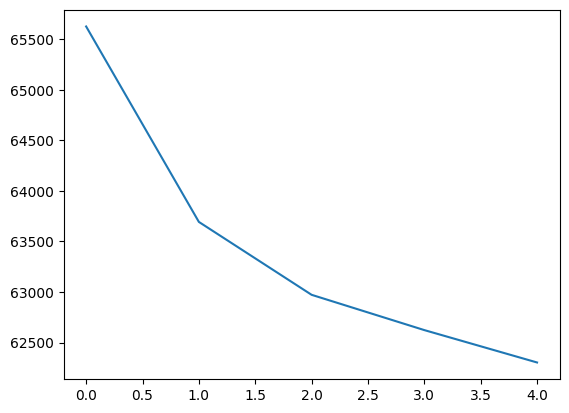

In [209]:
plt.plot(range(len(train_elbo)), train_elbo)

plt.show()

In [210]:
# print(prod_slda.beta_document())
# print(prod_slda.beta_meta())
for key, value in prod_slda.beta_meta().items():
    print(key, F.softmax(value,-1))

pos_bigrams tensor([[0.0022, 0.0025, 0.0032,  ..., 0.0049, 0.0048, 0.0027],
        [0.0033, 0.0048, 0.0018,  ..., 0.0017, 0.0019, 0.0031],
        [0.0032, 0.0045, 0.0020,  ..., 0.0019, 0.0021, 0.0033],
        [0.0023, 0.0026, 0.0035,  ..., 0.0051, 0.0044, 0.0026],
        [0.0021, 0.0025, 0.0036,  ..., 0.0055, 0.0049, 0.0025]])


In [211]:
path = 'prod_slda_saved_model'
prod_slda.eval()
torch.save(prod_slda, path)

# pyro.clear_param_store()
# prod_slda = torch.load(path)